In [18]:
import torch
# For dataset preparation
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
# For building neural networks
import torch.nn as nn
import torch.nn.functional as F
# For training
from torch.optim import SGD, Adam
# For visualization
import matplotlib.pyplot as plt

# Preparing the dataset

In [2]:
training_data = datasets.MNIST(
    # Where the data are stored. If this is a relative path, 
    # the path is assumed to start from the current working directory. 
    # Therefore you can find a data folder coming together with this notebook.
    root="./data",  
    train=True, 
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Defining the model

In [4]:
class AutoencoderCNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # To simply the code, let's use Sequential to define the encoder and the decoder,
        # instead of define a  
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, 7, 7]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), # [batch, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # [batch, 1, 28, 28]
            nn.Sigmoid(),  # for pixel values between 0 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [5]:
# Let's try to check if AutoencoderCNN works

model = AutoencoderCNN(32)
res = model(training_data[0][0].unsqueeze(0))
print(res[0].size())
print(res[1].size())

torch.Size([1, 32, 7, 7])
torch.Size([1, 1, 28, 28])


# Training: what typically works

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
def train_adam(model, dataloader, lr, epoches):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat = model(X)[1]
            loss = criterion(X, Xhat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat = model(X)[1]
                loss = criterion(X, Xhat)

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [17]:
model = model.to("cuda")
train_adam(model, training_dataloader, lr=0.002, epoches=5)

epoch   0   test loss avg: 0.000597
epoch   1   test loss avg: 0.000444
epoch   2   test loss avg: 0.000405
epoch   3   test loss avg: 0.000368
epoch   4   test loss avg: 0.000331


Time for a test

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


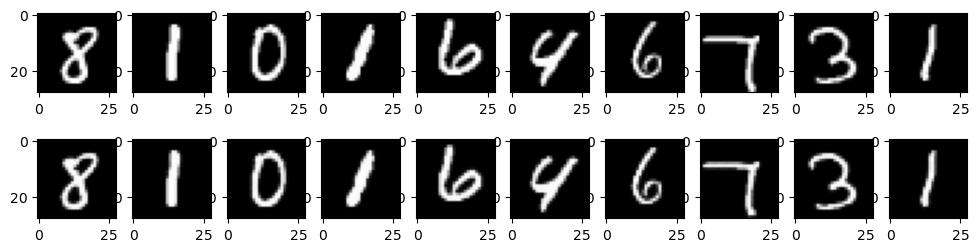

In [9]:
def show_reconstructed_images(model):
    for x, y in test_dataloader:
        break

    x = x.to(device)
    xb = model(x)[1]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images(model)

Does the model work with rotation?

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


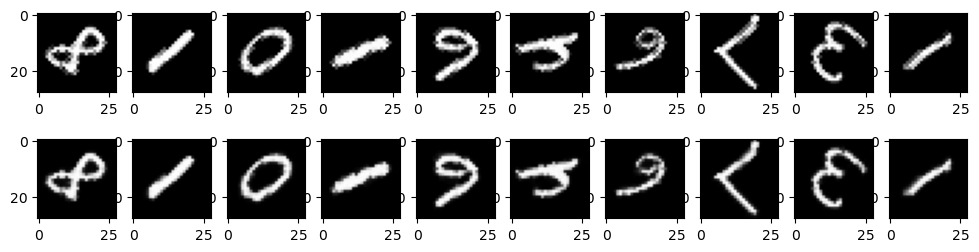

In [21]:
def show_reconstructed_images_rotated(model, angle):
    for x, y in test_dataloader:
        break

    x = TF.rotate(x, angle)
    x = x.to(device)
    xb = model(x)[1]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images_rotated(model, 135)

The procedure above works perfectly.
Now we see what makes it *not* work.

# SGD vs. Adam

In [10]:
def train_sgd(model, dataloader, lr, epoches):
    optimizer = SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat = model(X)[1]
            loss = criterion(X, Xhat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat = model(X)[1]
                loss = criterion(X, Xhat)

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [11]:
model = AutoencoderCNN(32)
model = model.to(device)

train_sgd(model, training_dataloader, 0.002, 5)

epoch   0   test loss avg: 0.166682
epoch   1   test loss avg: 0.141087
epoch   2   test loss avg: 0.126150
epoch   3   test loss avg: 0.117011
epoch   4   test loss avg: 0.111140


torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


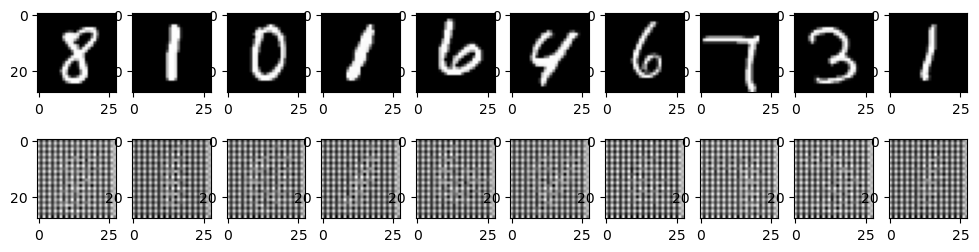

In [12]:
show_reconstructed_images(model)

Alright, so now we see grid-like predictions of the images.
This is an indication that the training is far from being completely yet:
what we're looking at are CNN kernels, in their default values,
creating patterns indicating how they stride.
This however can be solved by simply doing more epoches.

In [13]:
train_sgd(model, training_dataloader, 0.02, 40)

epoch   0   test loss avg: 0.096448
epoch   1   test loss avg: 0.091189
epoch   2   test loss avg: 0.073406
epoch   3   test loss avg: 0.048750
epoch   4   test loss avg: 0.036052
epoch   5   test loss avg: 0.028326
epoch   6   test loss avg: 0.022661
epoch   7   test loss avg: 0.018729
epoch   8   test loss avg: 0.016014
epoch   9   test loss avg: 0.014066
epoch  10   test loss avg: 0.012596
epoch  11   test loss avg: 0.011444
epoch  12   test loss avg: 0.010521
epoch  13   test loss avg: 0.009766
epoch  14   test loss avg: 0.009136
epoch  15   test loss avg: 0.008602
epoch  16   test loss avg: 0.008139
epoch  17   test loss avg: 0.007731
epoch  18   test loss avg: 0.007366
epoch  19   test loss avg: 0.007037
epoch  20   test loss avg: 0.006738
epoch  21   test loss avg: 0.006464
epoch  22   test loss avg: 0.006214
epoch  23   test loss avg: 0.005983
epoch  24   test loss avg: 0.005771
epoch  25   test loss avg: 0.005577
epoch  26   test loss avg: 0.005397
epoch  27   test loss avg: 0

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


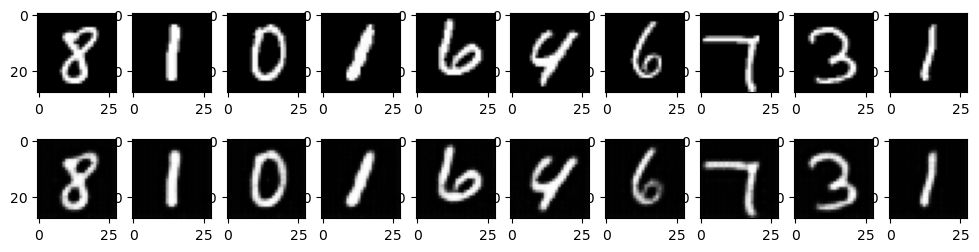

In [14]:
show_reconstructed_images(model)

Which works well enough.

# Learning rate